# Variant effect and variance explained analysis

This notebook aims to create visualisations of the `variant effect` and `variance explained` dataset generated by previous notebooks in this chapter.


In [ ]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import random


In [3]:
random.seed(42)
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("rocket"))


In [4]:
dataset = pl.read_parquet("rescaled-beta.parquet")


## Rescaled estimated beta vs MAF


In [2]:
df = pl.read_parquet("lead-maf-vep-rescaled-beta-ve.parquet")


CS size:

1. It seems there is no dependancy between maf and size of CS. I think, we don’t need figures for this. But for each of the five classes we need to calculate the linear regression CS_size~maf and see the p-value of the effect size of the maf. It should be insignificant (p-value>0.05)
2. The same per study type
3. It seems we do have the dependency between the size and sample size. We need linear regression for it as well. And probably one figure only for GWAS baed CSs, but I would make it the size vs log of sample size
4. Probably no need of sample size vs credible set size per studyType
5. Variance explained vs credible set size - Probably we have something here, but lets calualte linear regressions to see whether we have dependancy.
   Variance explained vs MAF
   No dependency here and it is fine. Just linear regressions to confirm.
   Variant effect counts
   Hm, this one is difficult. Could you please try to make a piechart of max vepScore per CSs for GWAS and for eQTLs, pQTLs, sQTLs and tuQTLs separately?
   On slightly diffrent note - could you please take only molQTL CSs and calculate the distributions of the distance of the lead variant and TSS of the corresponding gene?


### MAF vs credible set size


In [ ]:
def add_groups() -> pl.Expr:
    """Add groups to the DataFrame based on the study type and finemapping method."""
    gwas = pl.when(pl.col("studyType") == "gwas").then(pl.lit(True)).otherwise(pl.lit(False)).alias("gwas")
    molQTL = pl.when(pl.col("studyType") != "gwas").then(pl.lit(True)).otherwise(pl.lit(False)).alias("molQTL")
    gwas_pics = (
        pl.when((pl.col("studyType") == "gwas") & (pl.col("finemappingMethod") == "PICS"))
        .then(pl.lit(True))
        .otherwise(pl.lit(False))
        .alias("gwasPICS")
    )
    gwas_susie = (
        pl.when((pl.col("studyType") == "gwas") & (pl.col("finemappingMethod") != "PICS"))
        .then(pl.lit(True))
        .otherwise(pl.lit(False))
        .alias("gwasSuSiE")
    )

    return pl.struct(gwas, molQTL, gwas_pics, gwas_susie).alias("groups")


def bucketizer(col: pl.Expr, buckets: list[int] | list[float]) -> pl.Expr:
    expr = pl.when(False).then(None)
    for idx, bct in enumerate(buckets):
        if idx < len(buckets) - 1:
            expr = expr.when((col >= buckets[idx]) & (col < buckets[idx + 1])).then(bct)
    expr = expr.otherwise(buckets[-1])
    return expr


def bucketize_credible_sets_by_size() -> pl.Expr:
    """Bucketize the credible sets by size."""
    return bucketizer(pl.col("credibleSetSize"), [0, 10, 100, 1000]).alias("credibleSetSizeBucket")


def get_random_colors(n: int) -> list[str]:
    """Get random colors in hexadecimal format. Can create duplicates."""
    hexadecimal_alphabets = "0123456789ABCDEF"
    color = ["#" + "".join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n)]
    return color


def scatregplot(data: pl.DataFrame, x: str, y: str) -> figure.Figure:
    """Plot the scatterplot with regression groups."""
    matplotlib.rcParams["lines.markersize"] = 1
    fig = plt.figure(figsize=(9, 9))
    _data = data.select(x, y, pl.col("groups").struct.unnest(), pl.col("credibleSetSizeBucket"))
    credible_set_buckets = _data["credibleSetSizeBucket"].unique().to_numpy()
    credible_set_buckets.sort()
    groups = data["groups"].struct.fields
    colors = get_random_colors(len(groups))
    # for idx, cs_size in enumerate(credible_set_buckets):
    #     ax = fig.add_subplot(2, 2, idx + 1)

    #     _data_filtered = _data.filter(pl.col("credibleSetSizeBucket") == cs_size)
    #     _x = _data_filtered[x].to_numpy()
    #     _y = _data_filtered[y].to_numpy()

    #     ax.scatter(x=_x, y=_y)
    #     ax.set_xlabel(x)
    #     ax.set_ylabel(y)
    # ax.set_ylim(0, 4000)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_ylim(0, 200)
    ax.scatter(x=_data[x], y=_data[y], color="gray", alpha=0.1)
    for color, group in zip(colors, groups):
        _data_filtered = (
            _data.filter(pl.col(group))
            .filter(pl.col(x).is_not_nan() & ~pl.col(x).is_infinite())
            .filter(pl.col(y).is_not_nan() & ~pl.col(y).is_infinite())
        )
        _x = _data_filtered[x].to_numpy()
        _y = _data_filtered[y].to_numpy()
        slope, intercept, r_value, p_value, std_err = linregress(_x, _y.log)
        ax.plot(_x, slope * _x + intercept, label=f"{group} fit", color=color)
        print(
            f"group={group}: slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err} "
        )

    return fig


['gwas', 'molQTL', 'gwasPICS', 'gwasSuSiE']
group=gwas: slope=34.05474144402124, intercept=18.914658739313506, r_value=0.04613806479137148, p_value=1.5835864672843491e-268, std_err=0.9721954538366928 
group=molQTL: slope=7.951609824258522, intercept=22.69849340939596, r_value=0.014984321569520802, p_value=7.775416836995301e-102, std_err=0.37111216146973947 
group=gwasPICS: slope=48.309415483339016, intercept=23.832487859901484, r_value=0.062341817283283724, p_value=4.710091326944623e-171, std_err=1.731095507905227 
group=gwasSuSiE: slope=22.671971940893926, intercept=17.01098370085461, r_value=0.03151009132811602, p_value=3.983933647367663e-83, std_err=1.1734828376167838 


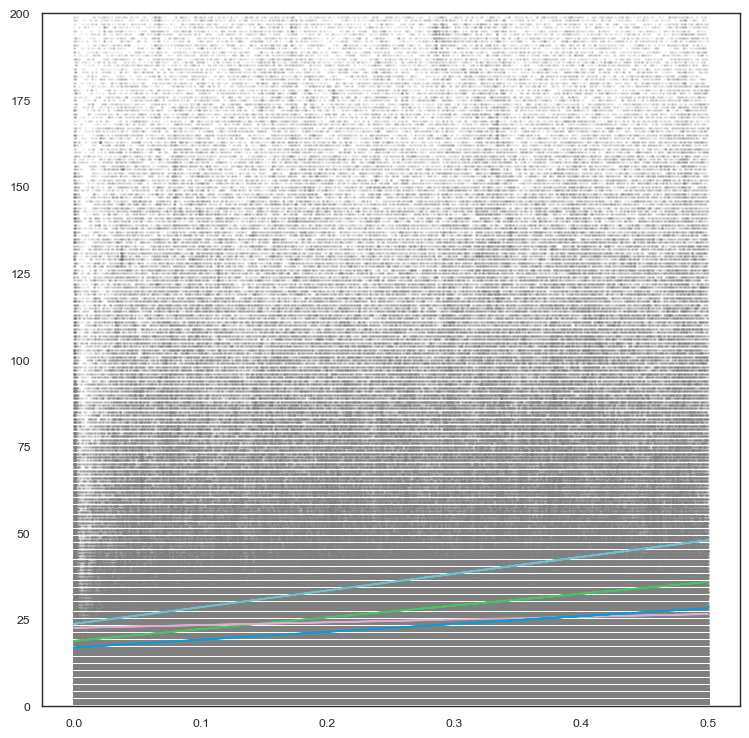

In [104]:
data = df.select(
    "studyType",
    "finemappingMethod",
    add_groups(),
    "credibleSetSize",
    bucketize_credible_sets_by_size(),
    "beta",
    "majorPopulationMAF",
)
print(data["groups"].struct.fields)
scatregplot(data=data, x="majorPopulationMAF", y="credibleSetSize")
plt.show()


In [ ]:
def plot_maf_vs_cs_size(data: pl.DataFrame, ax):
    assert "majorPopulationMAF" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("majorPopulationMAF"), pl.col("credibleSetSize")).filter(
        pl.col("majorPopulationMAF").is_not_null()
    )

    x = data["majorPopulationMAF"].to_numpy()
    y = data["credibleSetSize"].to_numpy()
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print(
        f"MAF vs CS size: slope={slope}, intercept={intercept}, r_value={r_value}, p_value={p_value}, std_err={std_err}"
    )

    sns.scatterplot(
        data=data,
        x="majorPopulationMAF",
        y="credibleSetSize",
        ax=ax,
        alpha=0.05,
        # line_kws=dict(color="r"),
    )
    sns.lineplot(
        data=data,
        x=x,
        y=x * slope + intercept,
        ax=ax,
        color="red",
        label="Linear fit",
        errorbar=None,
    )
    ax.set_ylim(0, 1000)

    ax.text(
        0.95,
        0.05,
        f"cs_size = {slope:.2f} * MAF + {intercept:.2f}, p-value={p_value:.2e} r={r_value:.2f}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=8,
        color="white",
    )

    return ax


def plot_maf_vs_cs_size_weighted(data: pl.DataFrame, ax):
    assert "majorPopulationMAF" in data.columns
    assert "credibleSetSize" in data.columns
    data = (
        data.select(pl.col("majorPopulationMAF"), pl.col("credibleSetSize"))
        .group_by("majorPopulationMAF", "credibleSetSize")
        .len()
        .select("majorPopulationMAF", "credibleSetSize", pl.col("len").alias("weight"))
    )
    return sns.relplot(
        data=data,
        x="majorPopulationMAF",
        y="credibleSetSize",
        size="weight",
        # alpha=0.05,
        sizes=(1, 100),
        ax=ax,
        # line_kws=dict(color="r"),
    )


def plot_af_vs_cs_size(data: pl.DataFrame, ax):
    assert "credibleSetSize" in data.columns
    assert "majorPopulationAlleleFrequency" in data.columns
    data = data.select(
        pl.col("majorPopulationAlleleFrequency")
        .list.first()
        .struct.field("alleleFrequency")
        .alias("majorPopulationAF"),
        pl.col("credibleSetSize"),
    )
    # print(data.schema)
    return sns.scatterplot(
        data=data,
        x="majorPopulationAF",
        y="credibleSetSize",
        ax=ax,
        alpha=0.05,
    )


def plot_n_vs_cs_size(data: pl.DataFrame, ax):
    assert "nSamples" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("nSamples"), pl.col("credibleSetSize"))
    return sns.lineplot(
        data=data,
        x="nSamples",
        y="credibleSetSize",
        ax=ax,
        errorbar=None,
        # alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_var_vs_cs_size(data: pl.DataFrame, ax):
    assert "leadVariantStats" in data.columns
    assert "credibleSetSize" in data.columns
    data = data.select(pl.col("leadVariantStats").struct.field("varianceExplained"), pl.col("credibleSetSize"))
    return sns.scatterplot(
        data=data,
        x="varianceExplained",
        y="credibleSetSize",
        ax=ax,
        # alpha=0.05,
        # line_kws=dict(color="r"),
    )


def plot_var_vs_MAF(data: pl.DataFrame, ax):
    assert "leadVariantStats" in data.columns
    assert "majorPopulationMAF" in data.columns
    data = data.select(pl.col("leadVariantStats").struct.field("varianceExplained"), pl.col("majorPopulationMAF"))
    return sns.scatterplot(
        data=data,
        y="varianceExplained",
        x="majorPopulationMAF",
        ax=ax,
        # alpha=0.05,
        # line_kws=dict(color="r"),
    )


### MAF vs credible set size


MAF vs CS size: slope=14.00187913542556, intercept=21.766520384667714, r_value=0.023887419947640844, p_value=0.0, std_err=0.3620694607258019
MAF vs CS size: slope=34.05474144402124, intercept=18.914658739313506, r_value=0.04613806479137148, p_value=1.5835864672843491e-268, std_err=0.9721954538366928
MAF vs CS size: slope=7.951609824258522, intercept=22.69849340939596, r_value=0.014984321569520802, p_value=7.775416836995301e-102, std_err=0.37111216146973947
MAF vs CS size: slope=48.309415483339016, intercept=23.832487859901484, r_value=0.062341817283283724, p_value=4.710091326944623e-171, std_err=1.731095507905227
MAF vs CS size: slope=22.671971940893926, intercept=17.01098370085461, r_value=0.03151009132811602, p_value=3.983933647367663e-83, std_err=1.1734828376167838


/var/folders/l7/4z91w2tj4wscfcpfjjy3s0mr0000gq/T/ipykernel_74430/2905256880.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


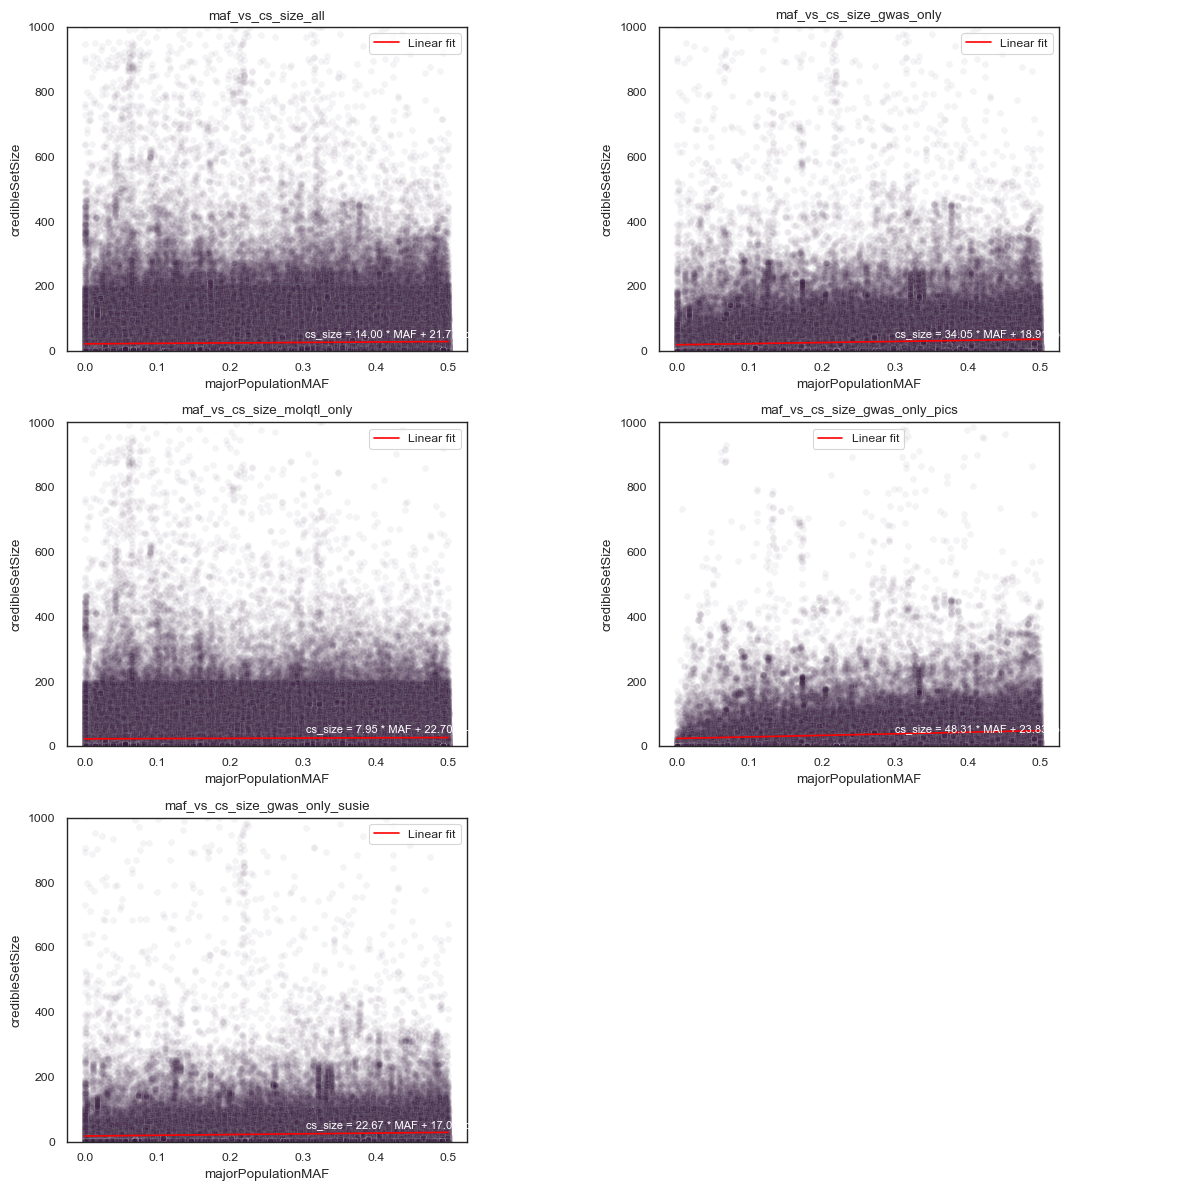

In [23]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_maf_vs_cs_size(data, ax1).set_title("maf_vs_cs_size_all")
plot_maf_vs_cs_size(data2, ax2).set_title("maf_vs_cs_size_gwas_only")
plot_maf_vs_cs_size(data3, ax3).set_title("maf_vs_cs_size_molqtl_only")
plot_maf_vs_cs_size(data4, ax4).set_title("maf_vs_cs_size_gwas_only_pics")
plot_maf_vs_cs_size(data5, ax5).set_title("maf_vs_cs_size_gwas_only_susie")


fig.tight_layout()

plt.show()


## Calculate the hist2 to see the fit


/var/folders/l7/4z91w2tj4wscfcpfjjy3s0mr0000gq/T/ipykernel_74430/3501618524.py:26: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.scatterplot(


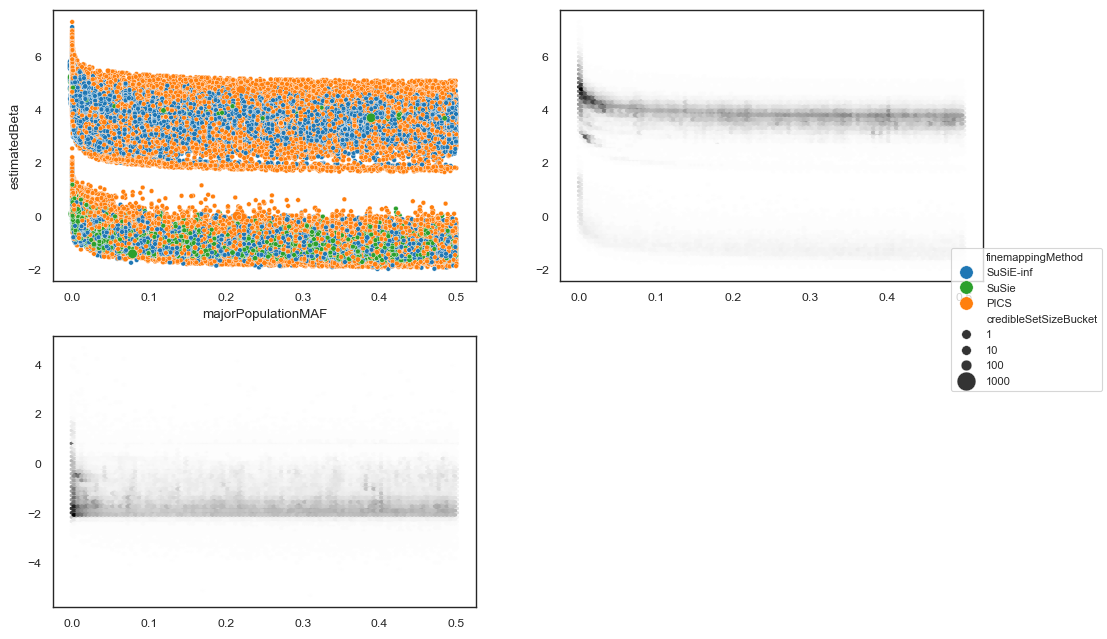

In [13]:
data = df
data_filtered = (
    (
        df.filter(pl.col("studyType") == "gwas").filter(pl.col("majorPopulationMAF").is_not_null())
        # .filter(pl.col("credibleSetSize") < 200)
    )
    .select(
        pl.col("majorPopulationMAF"),
        pl.col("pValueMantissa"),
        pl.col("credibleSetSize"),
        pl.col("beta").abs().log10().alias("log10Beta"),
        pl.col("beta"),
        pl.col("rescaledStatistics").struct.field("estimatedBeta").abs().log10().alias("estimatedBeta"),
        bucketizer(pl.col("credibleSetSize"), [1, 10, 100, 1000]).alias("credibleSetSizeBucket"),
        pl.when(pl.col("finemappingMethod") == "PICS").then(pl.lit("PICS")).otherwise(pl.lit("SuSiE")).alias("FM"),
        pl.col("finemappingMethod"),
    )
    .filter(pl.col("estimatedBeta").is_not_nan() & ~pl.col("estimatedBeta").is_infinite())
    .filter(pl.col("log10Beta").is_not_nan() & ~pl.col("log10Beta").is_infinite())
)
palette = ["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:brown"]
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
sns.scatterplot(
    x="majorPopulationMAF",
    y="estimatedBeta",
    data=data_filtered,
    ax=ax1,
    # style="FM",
    hue="finemappingMethod",
    palette=palette,
    size="credibleSetSizeBucket",
    # alpha=0.5,
    # col_wrap=2,
)
# ax1.set_ylim(0, 0.2)
ax2.hexbin(
    x=data_filtered["majorPopulationMAF"].to_numpy(),
    y=data_filtered["estimatedBeta"].to_numpy(),
    bins=100,
    cmap="binary",
)
ax2.set_ylabel("log10EstimatedBeta")
ax2.set_xlabel("MAF")

ax3.hexbin(
    x=data_filtered["majorPopulationMAF"].to_numpy(),
    y=data_filtered["log10Beta"].to_numpy(),
    bins=100,
    cmap="binary",
)
ax3.set_ylabel("log10StandardBeta")
ax3.set_xlabel("MAF")
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", fontsize=8, markerscale=2)

# fig.legend(loc="center right", fontsize=8, markerscale=2)
ax1.legend().remove()

plt.show()


[   1   10  100 1000]
PICS 0 0 1
SuSiE 0 1 2
PICS 1 0 3
SuSiE 1 1 4
PICS 2 0 5
SuSiE 2 1 6
PICS 3 0 7
SuSiE 3 1 8


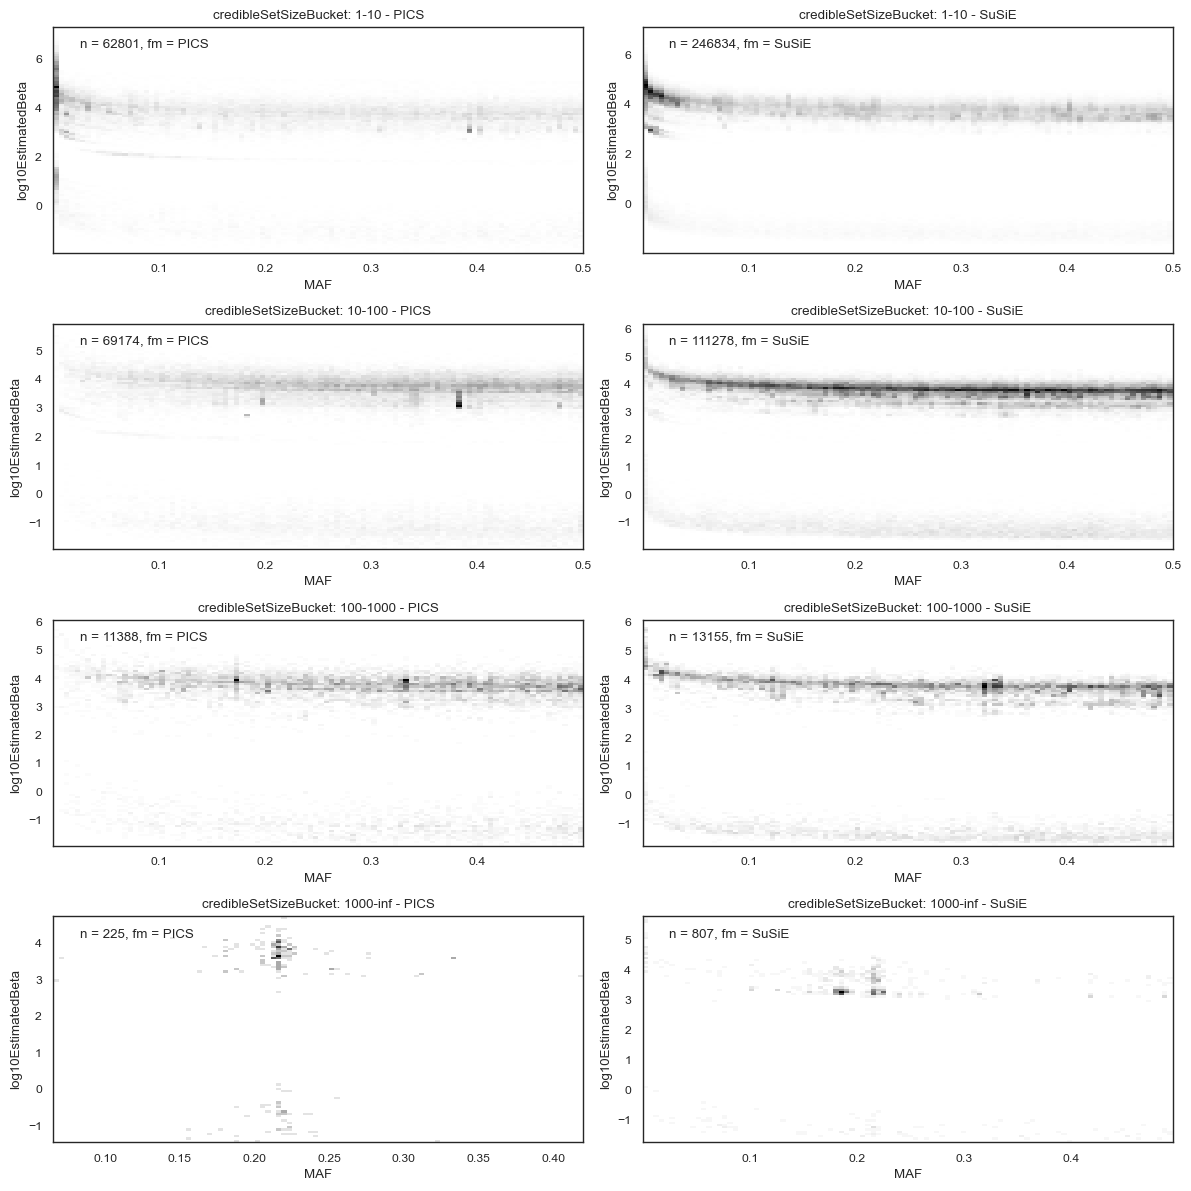

In [178]:
fig2 = plt.figure(figsize=(12, 12))
buckets = data_filtered["credibleSetSizeBucket"].unique().to_numpy()
print(buckets)

for i, bucket in enumerate(buckets):
    _data = data_filtered.filter(pl.col("credibleSetSizeBucket") == bucket).select(
        pl.col("majorPopulationMAF"), pl.col("estimatedBeta"), pl.col("FM")
    )
    for j, fm in enumerate(["PICS", "SuSiE"]):
        ax = plt.subplot(4, 2, i * 1 + j + i + 1)
        _data2 = _data.filter(pl.col("FM") == fm)
        ax.hist2d(
            x=_data2["majorPopulationMAF"].to_numpy(),
            y=_data2["estimatedBeta"].to_numpy(),
            bins=100,
            cmap="binary",
        )
        ax.set_ylabel("log10EstimatedBeta")
        ax.set_xlabel("MAF")
        ax.set_title(f"credibleSetSizeBucket: {buckets[i]}-{buckets[i + 1] if i + 1 < len(buckets) else 'inf'} - {fm}")
        ax.text(
            0.05,
            0.95,
            f"n = {len(_data2)}, fm = {fm}",
            horizontalalignment="left",
            verticalalignment="top",
            transform=ax.transAxes,
        )
    # ax.set_yscale("log")
# ax2.set_ylim(0, 300000)
fig2.tight_layout()
plt.show()


[   1   10  100 1000]


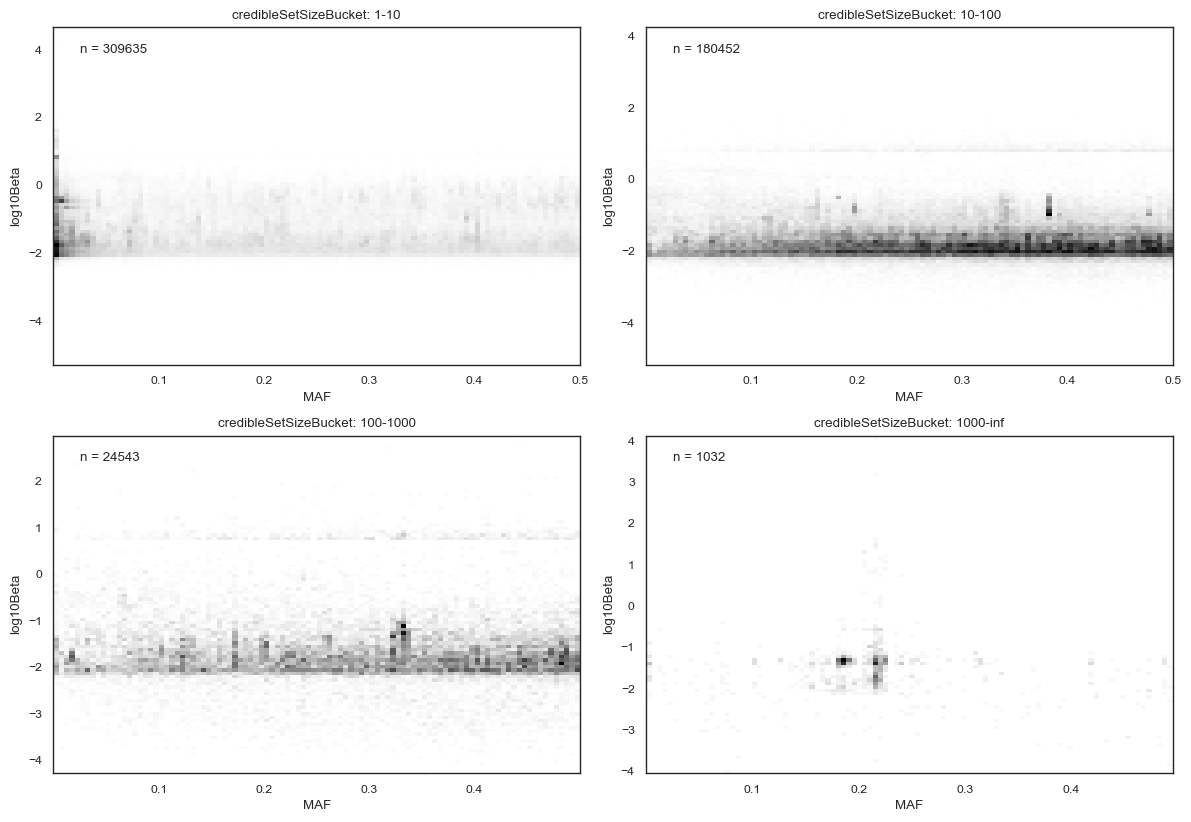

In [152]:
fig2 = plt.figure(figsize=(12, 12))
buckets = data_filtered["credibleSetSizeBucket"].unique().to_numpy()
print(buckets)

for i, bucket in enumerate(buckets):
    _data = data_filtered.filter(pl.col("credibleSetSizeBucket") == bucket).select(
        pl.col("majorPopulationMAF"), pl.col("log10Beta")
    )
    ax = plt.subplot(3, 2, i + 1)
    ax.hist2d(
        x=_data["majorPopulationMAF"].to_numpy(),
        y=_data["log10Beta"].to_numpy(),
        bins=100,
        cmap="binary",
        # norm=mcolors.PowerNorm(0.3)÷,
    )
    ax.set_ylabel("log10Beta")
    ax.set_xlabel("MAF")
    ax.set_title(f"credibleSetSizeBucket: {buckets[i]}-{buckets[i + 1] if i + 1 < len(buckets) else 'inf'}")
    ax.text(
        0.05,
        0.95,
        f"n = {len(_data)}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )
    # ax.set_yscale("log")
# ax2.set_ylim(0, 300000)
fig2.tight_layout()
plt.show()


### MAF vs credible set size per studyType


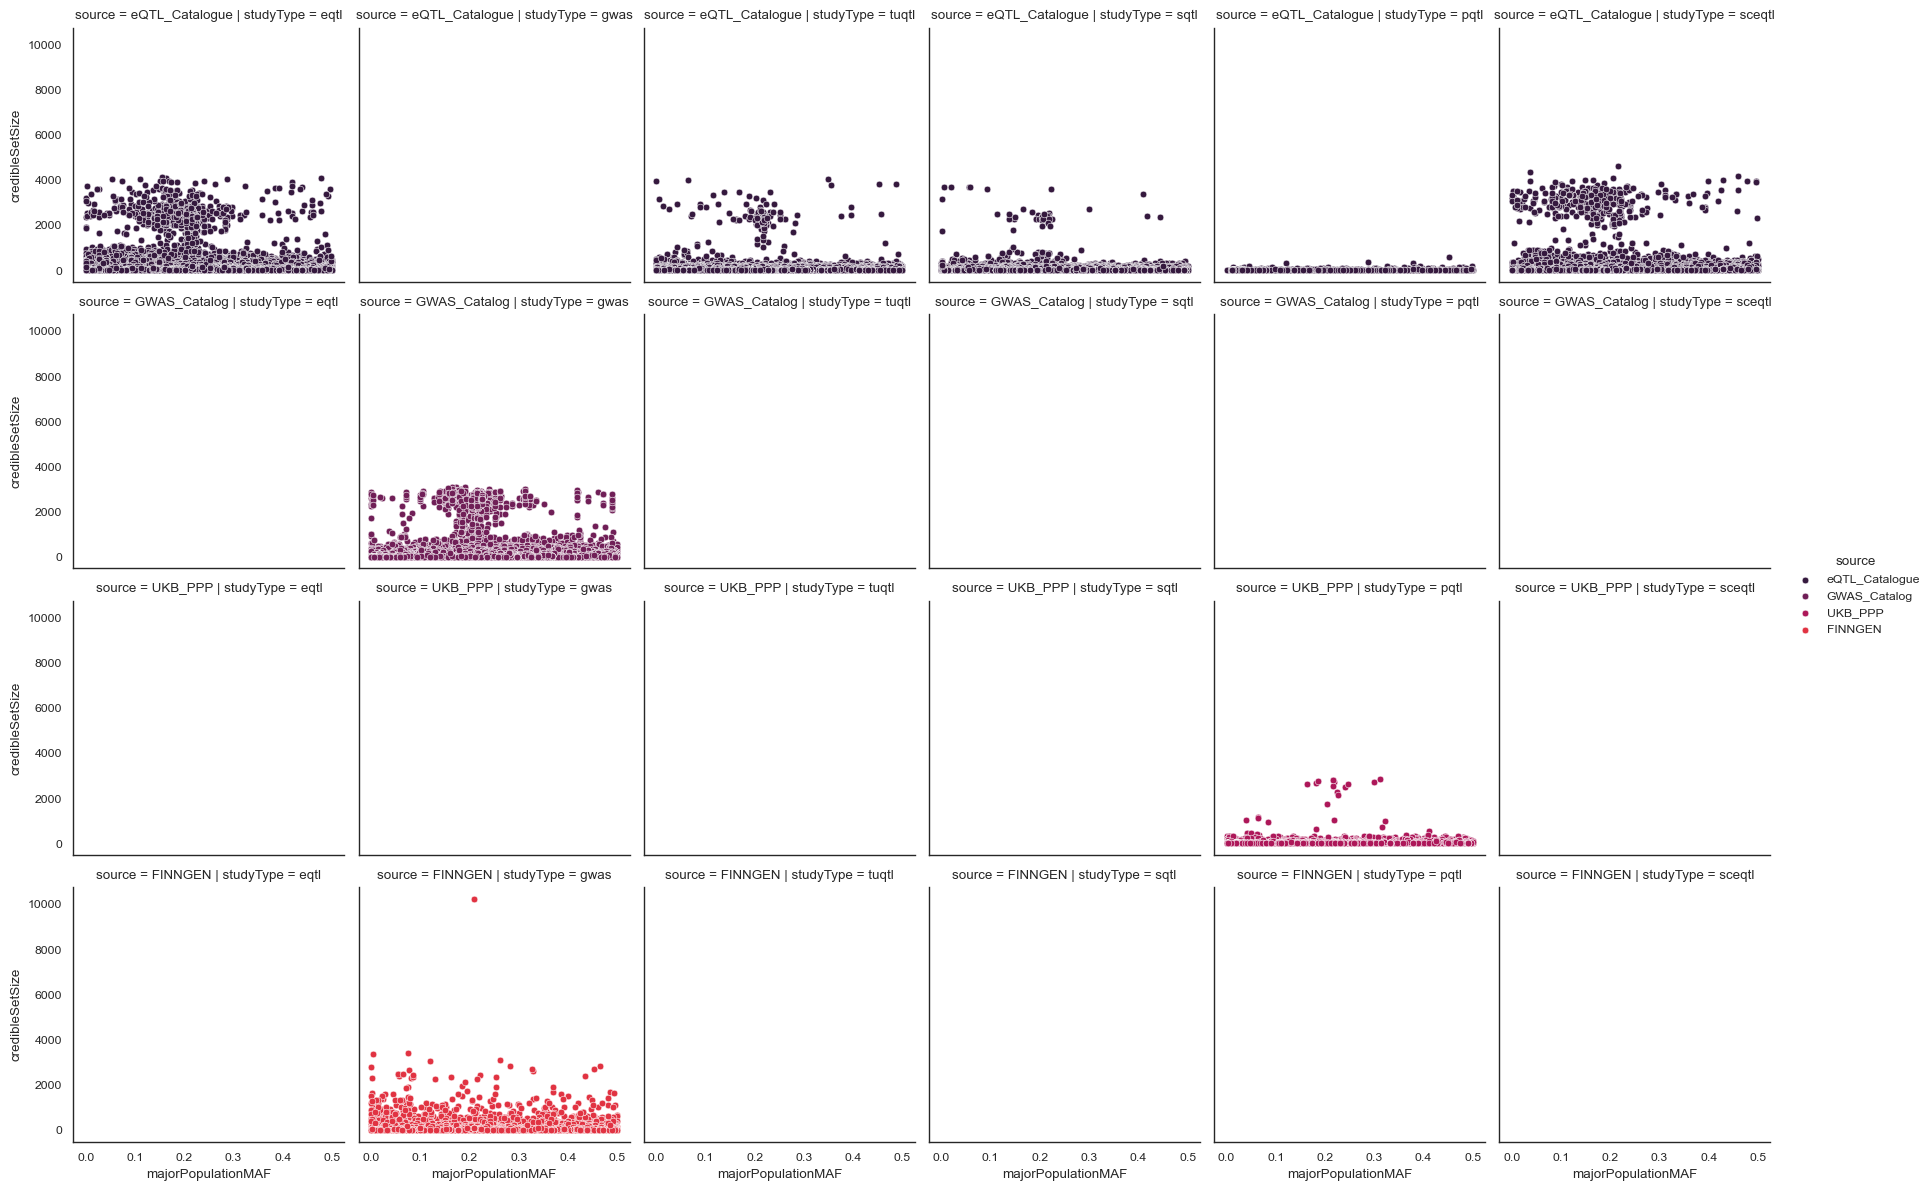

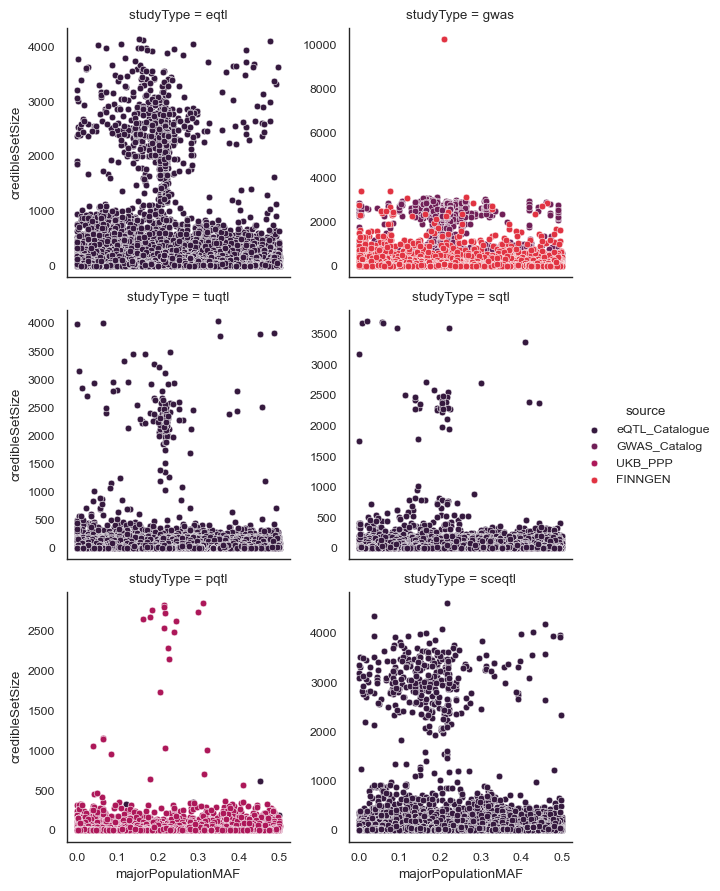

In [ ]:
data = df.select(
    "majorPopulationMAF",
    "credibleSetSize",
    "studyType",
    "studyId",
    pl.when(pl.col("studyId").str.starts_with("GCST"))
    .then(pl.lit("GWAS_Catalog"))
    .when(pl.col("studyId").str.starts_with("FINNGEN"))
    .then(pl.lit("FINNGEN"))
    .when(pl.col("studyId").str.starts_with("UKB"))
    .then(pl.lit("UKB_PPP"))
    .otherwise(pl.lit("eQTL_Catalogue"))
    .alias("source"),
)
g = sns.FacetGrid(data, col="studyType", row="source", hue="source")
g.map(sns.scatterplot, "majorPopulationMAF", "credibleSetSize")
g.add_legend()

g2 = sns.FacetGrid(data, col="studyType", hue="source", col_wrap=2, sharey=False)
g2.map(
    sns.scatterplot,
    "majorPopulationMAF",
    "credibleSetSize",
)
g2.add_legend()

plt.show()


### sample size vs credible set size


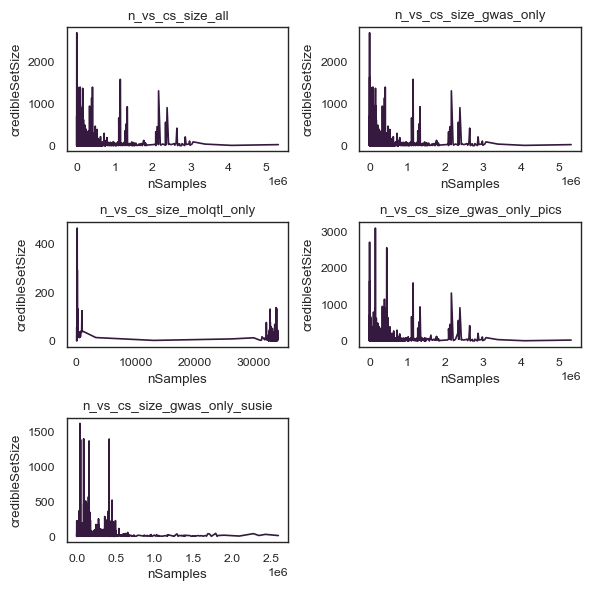

In [25]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_n_vs_cs_size(data, ax1).set_title("n_vs_cs_size_all")
plot_n_vs_cs_size(data2, ax2).set_title("n_vs_cs_size_gwas_only")
plot_n_vs_cs_size(data3, ax3).set_title("n_vs_cs_size_molqtl_only")
plot_n_vs_cs_size(data4, ax4).set_title("n_vs_cs_size_gwas_only_pics")
plot_n_vs_cs_size(data5, ax5).set_title("n_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


### sample size vs credible set size per studyType


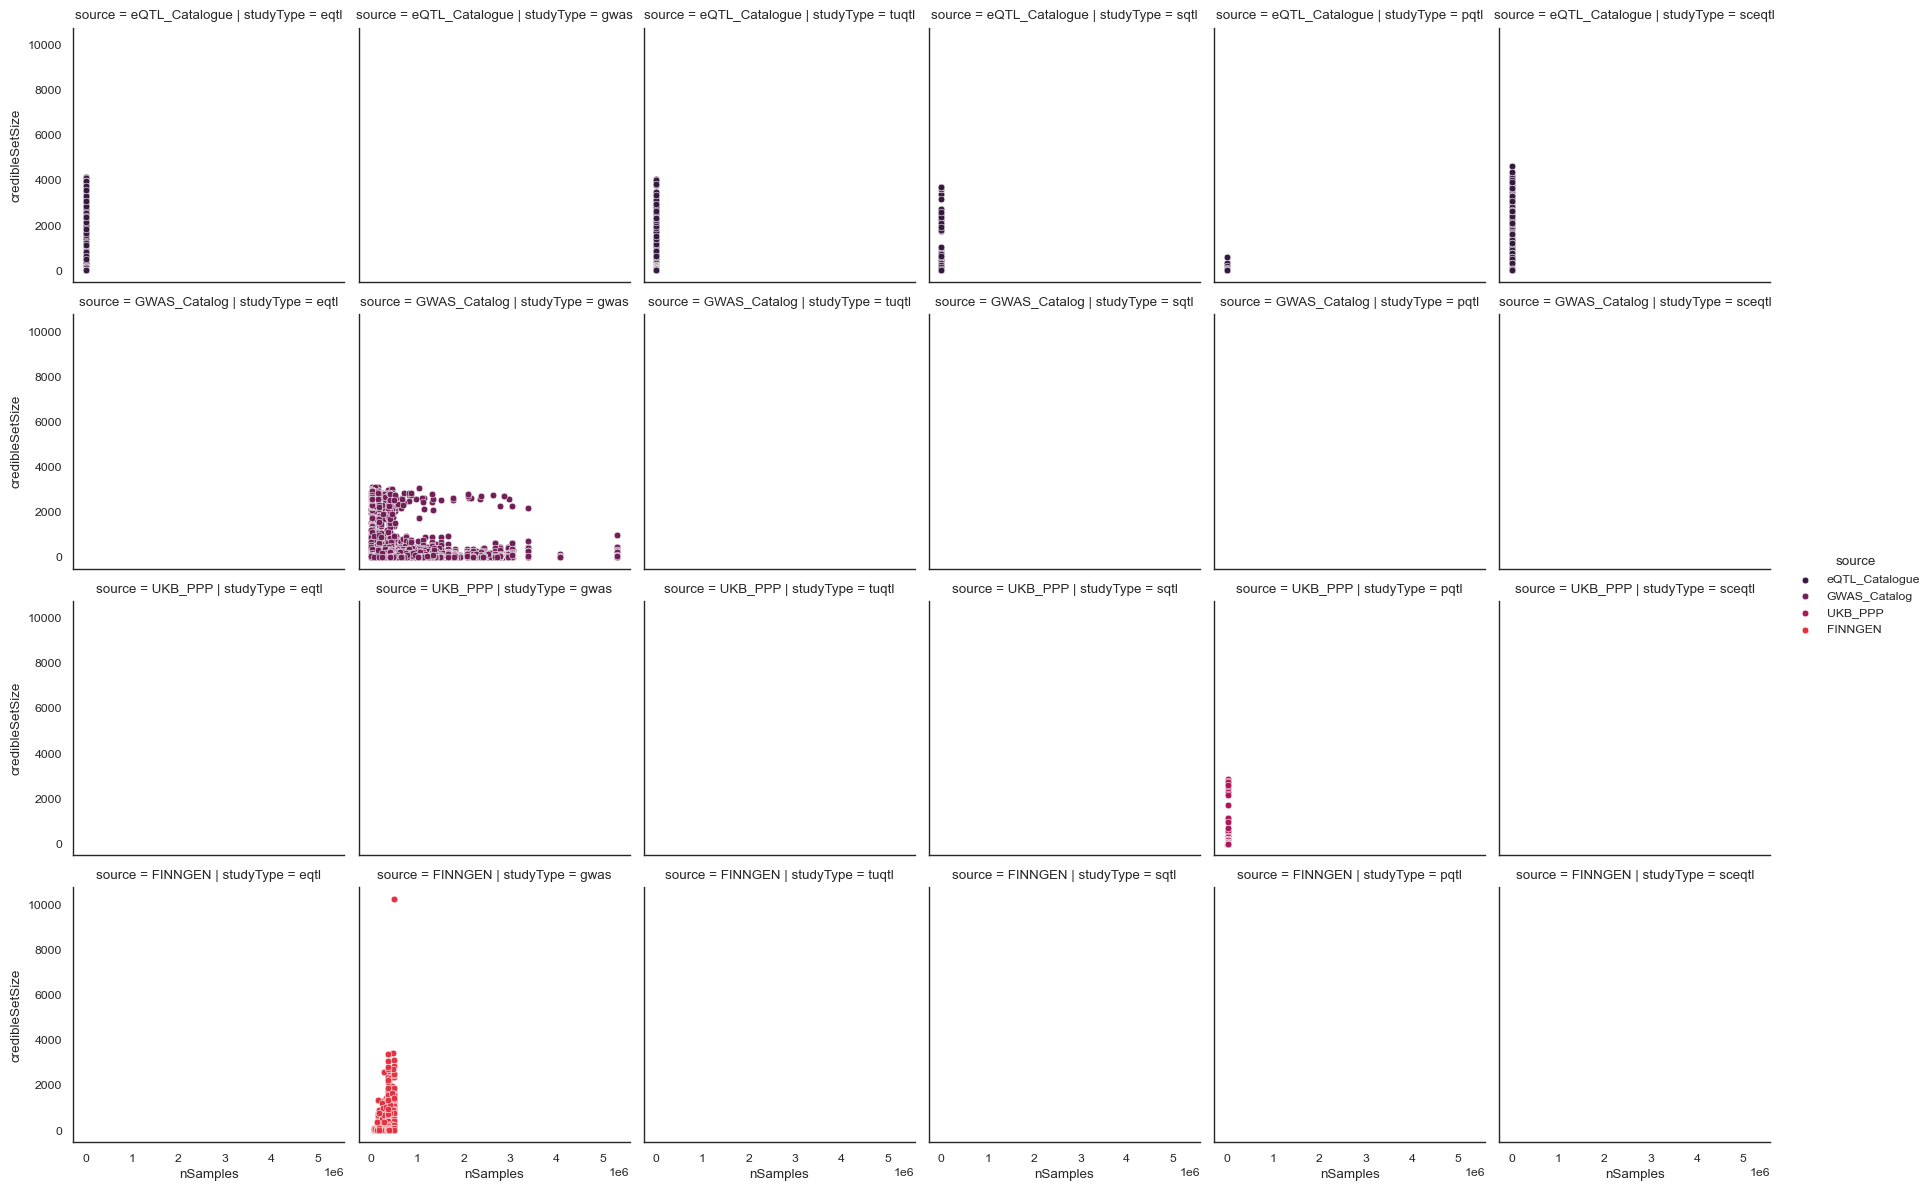

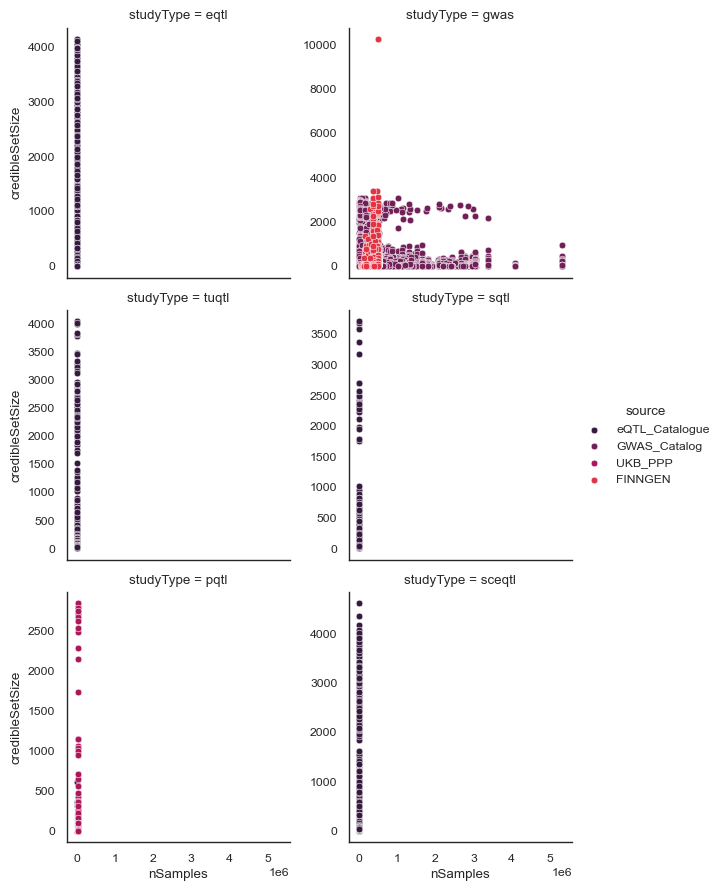

In [8]:
data = df.select(
    "nSamples",
    "credibleSetSize",
    "studyType",
    "studyId",
    pl.when(pl.col("studyId").str.starts_with("GCST"))
    .then(pl.lit("GWAS_Catalog"))
    .when(pl.col("studyId").str.starts_with("FINNGEN"))
    .then(pl.lit("FINNGEN"))
    .when(pl.col("studyId").str.starts_with("UKB"))
    .then(pl.lit("UKB_PPP"))
    .otherwise(pl.lit("eQTL_Catalogue"))
    .alias("source"),
)
g = sns.FacetGrid(data, col="studyType", row="source", hue="source")
g.map(sns.scatterplot, "nSamples", "credibleSetSize")
g.add_legend()

g2 = sns.FacetGrid(data, col="studyType", hue="source", col_wrap=2, sharey=False)
g2.map(
    sns.scatterplot,
    "nSamples",
    "credibleSetSize",
)
g2.add_legend()

plt.show()


### Distributions


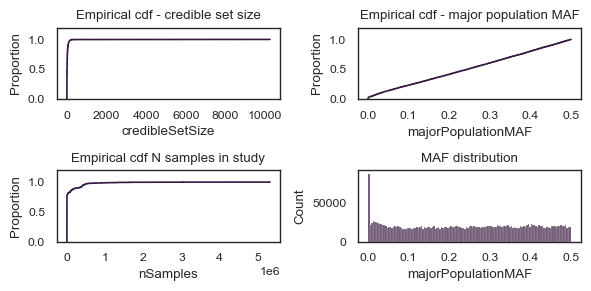

In [9]:
data = df
fig2 = plt.figure(figsize=(6, 3))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
sns.ecdfplot(data=data.select("credibleSetSize"), x="credibleSetSize", ax=ax1)
ax1.set_title("Empirical cdf - credible set size")
ax1.set_ylim(ymax=1.2)
ax1.set_yticks([0.0, 0.5, 1.0])
# ax1.axhline(y=1.0, color="red", linestyle="--")

sns.ecdfplot(data=data.select("majorPopulationMAF"), x="majorPopulationMAF", ax=ax2)
ax2.set_title("Empirical cdf - major population MAF")
ax2.set_ylim(ymax=1.2)
ax2.set_yticks([0.0, 0.5, 1.0])
sns.ecdfplot(data=data.select("nSamples"), x="nSamples", ax=ax3)
ax3.set_title("Empirical cdf N samples in study")
ax3.set_ylim(ymax=1.2)
ax3.set_yticks([0.0, 0.5, 1.0])
sns.histplot(data=data.select("majorPopulationMAF"), x="majorPopulationMAF", ax=ax4)
ax4.set_title("MAF distribution")
fig2.tight_layout()

plt.show()


### variance explained vs credible set size


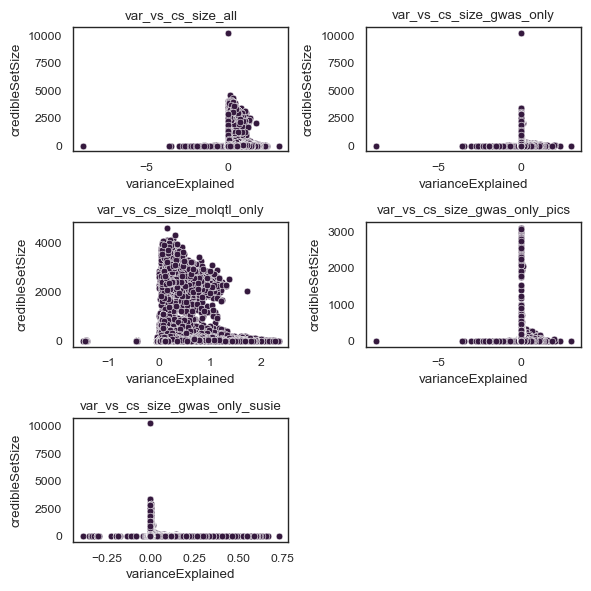

In [14]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_var_vs_cs_size(data, ax1).set_title("var_vs_cs_size_all")
plot_var_vs_cs_size(data2, ax2).set_title("var_vs_cs_size_gwas_only")
plot_var_vs_cs_size(data3, ax3).set_title("var_vs_cs_size_molqtl_only")
plot_var_vs_cs_size(data4, ax4).set_title("var_vs_cs_size_gwas_only_pics")
plot_var_vs_cs_size(data5, ax5).set_title("var_vs_cs_size_gwas_only_susie")
fig.tight_layout()

plt.show()


### variance explained vs MAF


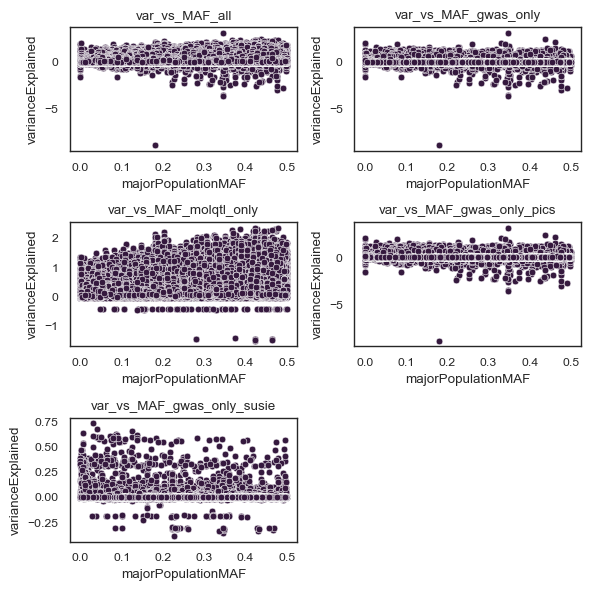

In [15]:
data = df
data2 = df.filter(pl.col("studyType") == "gwas")
data3 = df.filter(pl.col("studyType") != "gwas")
data4 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") == "PICS")
data5 = df.filter(pl.col("studyType") == "gwas").filter(pl.col("finemappingMethod") != "PICS")

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
plot_var_vs_MAF(data, ax1).set_title("var_vs_MAF_all")
plot_var_vs_MAF(data2, ax2).set_title("var_vs_MAF_gwas_only")
plot_var_vs_MAF(data3, ax3).set_title("var_vs_MAF_molqtl_only")
plot_var_vs_MAF(data4, ax4).set_title("var_vs_MAF_gwas_only_pics")
plot_var_vs_MAF(data5, ax5).set_title("var_vs_MAF_gwas_only_susie")
fig.tight_layout()

plt.show()


### variant effect counts


we have 903816 unique variants in credible sets


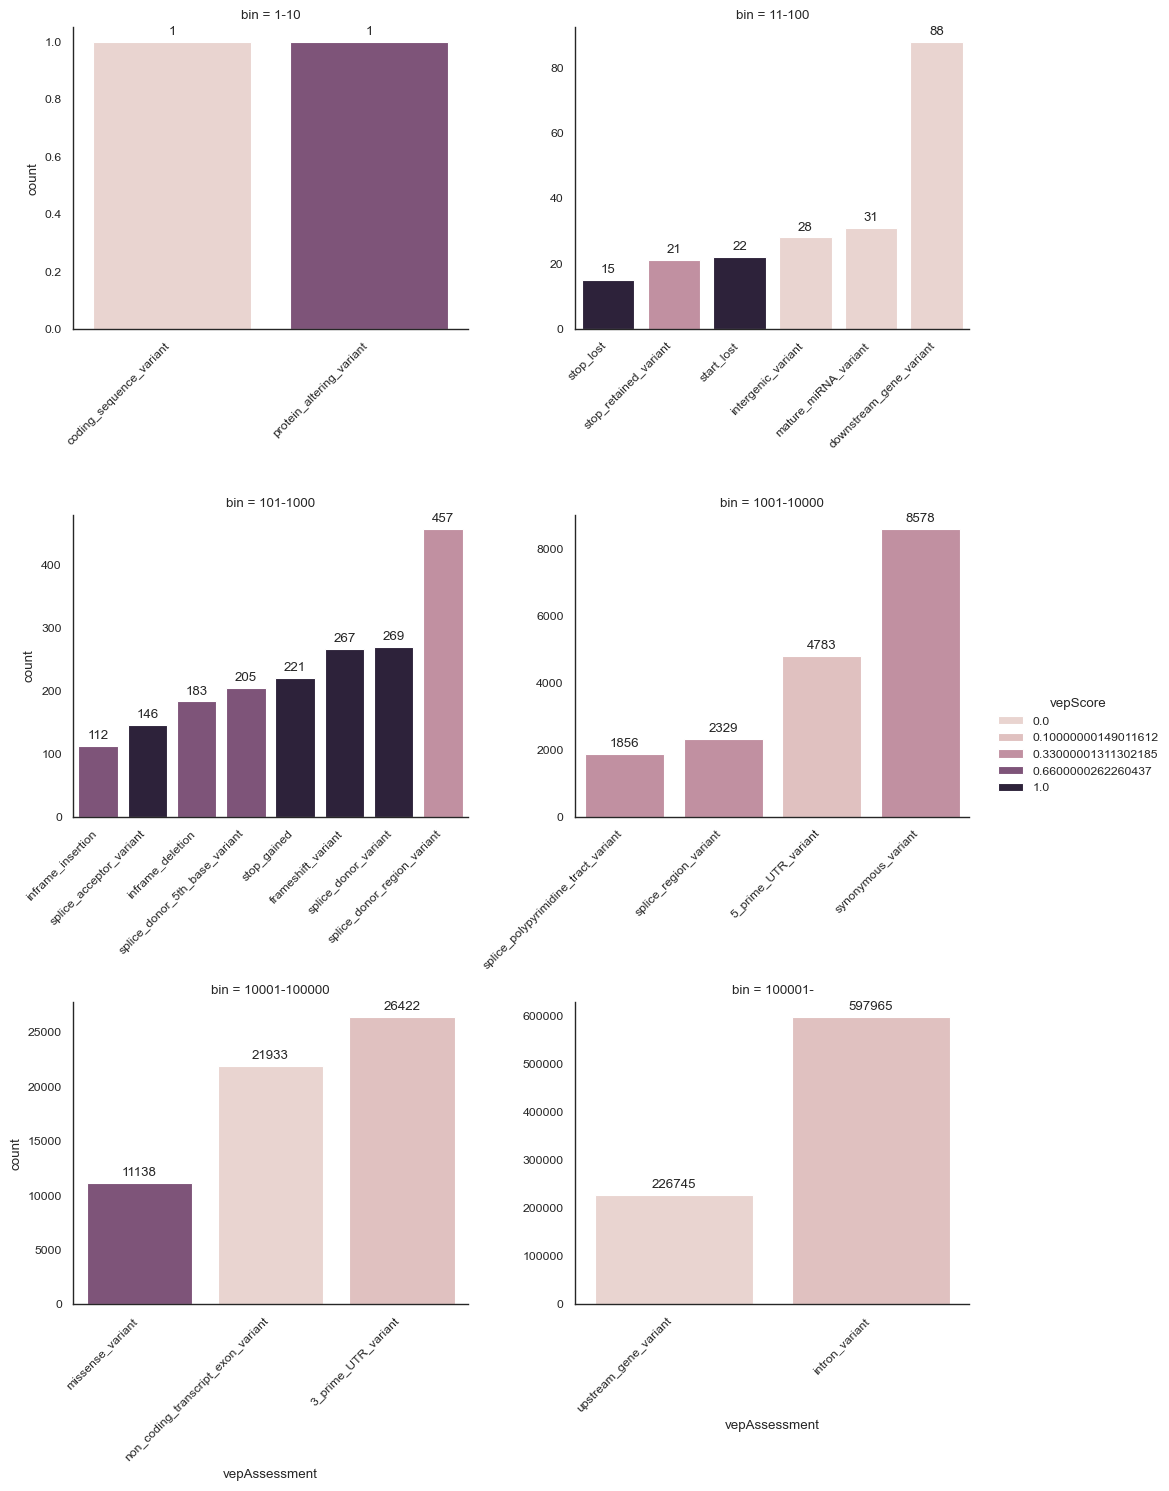

In [75]:
threshold = 1000

bins = [(0, 10), (10, 100), (100, 1000), (1000, 10000), (10000, 100000)]
bin_names = [f"{b[0] + 1}-{b[1]}" for b in bins]
last_bin_name = f"{bins[-1][1] + 1}-"
start = pl.when(pl.col("count") <= bins[0][1]).then(pl.lit(bin_names[0]))
step = start
for idx, bin in enumerate(bins[1:]):
    step = step.when(pl.col("count") <= bin[1]).then(pl.lit(bin_names[idx + 1]))

step = step.otherwise(pl.lit(last_bin_name))

n_variants = df.select("variantId").unique().shape[0]

data = (
    df.select(
        pl.col("vepEffect").struct.field("assessment").alias("vepAssessment"),
        pl.col("vepEffect").struct.field("normalisedScore").alias("vepScore"),
        pl.col("variantId"),
    )
    .unique(subset=["variantId"])
    .group_by("vepAssessment")
    .agg(
        pl.len().alias("count"),
        pl.max("vepScore").alias("vepScore"),
    )
    .sort(by="count")
    .with_columns(bin=step)
)
print(f"we have {n_variants} unique variants in credible sets")
g = sns.catplot(
    data=data,
    x="vepAssessment",
    y="count",
    kind="bar",
    col="bin",
    sharey=False,
    hue="vepScore",
    sharex=False,
    col_wrap=2,
)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)  #
        label.set_horizontalalignment("right")  # or 'left', 'center' depending on rotation direction
    for container in ax.containers:
        ax.bar_label(container, padding=3)
g.tight_layout()
plt.show()


We have ~900k unique lead variants
